In [89]:
from keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)


df = pd.read_csv('csv_dateien/starcraftFinalcsvs/allRunsButOnlyTerran.csv')

conditions = [
    (df['fraction'] == "Protoss"), #1
    (df['fraction'] == "Terraner"), #2
    (df['fraction'] == "Zerg"), #3
    (df['fraction'] == "T"), #2
]

values = [1, 2, 3, 2]

df["fraction"] = np.select(conditions, values)
df=df[df["total_army"]>0]
df=df[df["fraction"]==2]
df=df[df["supply"]<=200]
# df["ratio"] = df["total_workers"]/df["total_army"]

dfPrepSample = df.drop(columns=["player","winner","replay_filename", "Unnamed: 0", "total_army_value","fraction"])
len(dfPrepSample)


3009

In [90]:
df_sample = dfPrepSample.sample(frac=1, random_state=12)
dfTrainSample = df_sample.sample(frac=0.8)

dfTrainSample.head()

,total_workers,resource_mining,total_army,supply,time
3566,45,15797,25.0,78.0,580
4143,79,52965,82.0,172.0,1027
5018,67,25374,78.0,149.0,678
4269,29,8689,16.0,54.0,400
4640,40,13056,56.0,102.0,607


In [91]:
dfTestSample = df_sample.drop(dfTrainSample.index)

dfTestSample.head()

,total_workers,resource_mining,total_army,supply,time
5087,71,34267,45.0,133.0,720
3646,67,20336,67.0,157.0,759
4779,42,9805,17.0,70.0,428
5570,52,12178,38.0,117.0,571
5489,48,11679,30.0,94.0,514


In [92]:
dfTrainFeatures = dfTrainSample.copy()
dfTrainFeatures

,total_workers,resource_mining,total_army,supply,time
3566,45,15797,25.0,78.0,580
4143,79,52965,82.0,172.0,1027
5018,67,25374,78.0,149.0,678
4269,29,8689,16.0,54.0,400
4640,40,13056,56.0,102.0,607
...,...,...,...,...,...
3806,29,10313,10.0,46.0,432
4902,49,19974,59.0,134.0,687
5417,43,8704,22.0,86.0,456
3387,40,13100,19.0,70.0,475


In [93]:

dfTrainLabels = dfTrainFeatures.pop("total_army")
dfTrainFeatures = np.array(dfTrainFeatures)
dfTrainFeatures

array([[   45., 15797.,    78.,   580.],
       [   79., 52965.,   172.,  1027.],
       [   67., 25374.,   149.,   678.],
       ...,
       [   43.,  8704.,    86.,   456.],
       [   40., 13100.,    70.,   475.],
       [   46., 22066.,   126.,   713.]])

In [94]:
# normalize = layers.Normalization()
# normalize.adapt(dfTrainFeatures)

In [95]:
sc_model = tf.keras.Sequential([layers.Dense(3, activation="relu"),layers.Dense(3, activation="relu"), layers.Dense(1)]) # letzte lösung 30/5

sc_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())

In [96]:
sc_model.fit(dfTrainFeatures, dfTrainLabels, epochs=600)  #350

Epoch 1/600
76/76 [==============================] - 0s 602us/step - loss: 636366.3750
Epoch 2/600
76/76 [==============================] - 0s 585us/step - loss: 83773.8828
Epoch 3/600
76/76 [==============================] - 0s 739us/step - loss: 9379.5410
Epoch 4/600
76/76 [==============================] - 0s 640us/step - loss: 1200.6813
Epoch 5/600
76/76 [==============================] - 0s 583us/step - loss: 666.3084
Epoch 6/600
76/76 [==============================] - 0s 586us/step - loss: 644.9007
Epoch 7/600
76/76 [==============================] - 0s 587us/step - loss: 641.5583
Epoch 8/600
76/76 [==============================] - 0s 616us/step - loss: 637.7810
Epoch 9/600
76/76 [==============================] - 0s 574us/step - loss: 634.1191
Epoch 10/600
76/76 [==============================] - 0s 574us/step - loss: 630.2195
Epoch 11/600
76/76 [==============================] - 0s 657us/step - loss: 626.4380
Epoch 12/600
76/76 [==============================] - 0s 592us/step

In [97]:
dfTestFeatures = dfTestSample.copy()

dfTestLabels = dfTestFeatures.pop("total_army")
dfTestFeatures = np.array(dfTestFeatures)
dfTestLabels.head()

5087    45.0
3646    67.0
4779    17.0
5570    38.0
5489    30.0
Name: total_army, dtype: float64

In [98]:
from sklearn.metrics import r2_score


predictedValues = sc_model.predict(dfTestFeatures)
r2_score_sc = (r2_score(dfTestLabels, predictedValues))
stri = ""
if(r2_score_sc<0):
    stri = "negative" + str(r2_score_sc)
else:
    stri = str(r2_score_sc)

print(f"The R^2 value in the test set is {stri}")

19/19 [==============================] - 0s 524us/step
The R^2 value in the test set is 0.9177098179854615


In [99]:
# optimizer with scaling and lin reg

import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr



# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfOpt = dfPrepSample.drop(columns=[
                               "total_workers"])

dfOpt.head



<bound method NDFrame.head of       resource_mining  total_army  supply  time
1               28154        96.0   174.0   836
6               40998       120.0   196.0   934
15              13965        45.0   117.0   583
19               9595        26.0    62.0   449
24              38030        98.0   165.0  1102
...               ...         ...     ...   ...
5888             7364        17.0    69.0   381
5889            25845        80.0   173.0   878
5893            26351        70.0   157.0   795
5894            24263        76.0   165.0   754
5895            22655        40.0   125.0   726

[3009 rows x 4 columns]>

In [100]:

# create variables
# create Model

m = gp.Model("Balance optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfOpt,
                  name="total_workers")

a = gppd.add_vars(m, pandas_obj=dfOpt,
                  name="total_army")
s = gppd.add_vars(m, pandas_obj=dfOpt,
                  name="supply")

m.update()
dfOpt = dfOpt.drop(columns=["total_army"])

feats = dfOpt
feats = pd.concat([w, feats], axis=1)
feats.head


<bound method NDFrame.head of                          total_workers  resource_mining  supply  time
1        <gurobi.Var total_workers[1]>            28154   174.0   836
6        <gurobi.Var total_workers[6]>            40998   196.0   934
15      <gurobi.Var total_workers[15]>            13965   117.0   583
19      <gurobi.Var total_workers[19]>             9595    62.0   449
24      <gurobi.Var total_workers[24]>            38030   165.0  1102
...                                ...              ...     ...   ...
5888  <gurobi.Var total_workers[5888]>             7364    69.0   381
5889  <gurobi.Var total_workers[5889]>            25845   173.0   878
5893  <gurobi.Var total_workers[5893]>            26351   157.0   795
5894  <gurobi.Var total_workers[5894]>            24263   165.0   754
5895  <gurobi.Var total_workers[5895]>            22655   125.0   726

[3009 rows x 4 columns]>

In [101]:


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
"""
gppd.add_constrs(m, ((av - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
"""

gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, s) # Gleichung 4
m.update()


In [102]:

pred_constr = add_predictor_constr(m, sc_model, feats, a) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.Params.NonConvex = 2
m.optimize()


Model for sequential1:
45135 variables
21063 constraints
18054 general constraints
Input has shape (3009, 4)
Output has shape (3009, 1)

--------------------------------------------------------------------------------
Layer           Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
dense0             (3009, 3)        18054         9027            0         9027 (relu)

dense1             (3009, 3)        18054         9027            0         9027 (relu)

dense2             (3009, 1)            0         3009            0            0

--------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize 

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\nicol\AppData\Roaming\Python\Python310\site-packages\ipykernel\iostream.py", line 535, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


In [ ]:


outputs = pred_constr.input_values
pred_constr.input_values


,total_workers,resource_mining,supply,time
1,80704.703713,28154.0,174.0,836.0
6,117505.995366,40998.0,196.0,934.0
15,40041.331300,13965.0,117.0,583.0
19,27515.612708,9595.0,62.0,449.0
24,109016.267384,38030.0,165.0,1102.0
...,...,...,...,...
5888,21119.211410,7364.0,69.0,381.0
5889,74092.779281,25845.0,173.0,878.0
5893,75537.470013,26351.0,157.0,795.0
5894,69552.538573,24263.0,165.0,754.0


In [ ]:


solution = pd.DataFrame()

solution["ratio"] = w.gppd.X
solution["supply"] = s.gppd.X
solution["total_army"] = a.gppd.X
# solution["workers"] = w
solution


NameError: name 'r' is not defined

c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


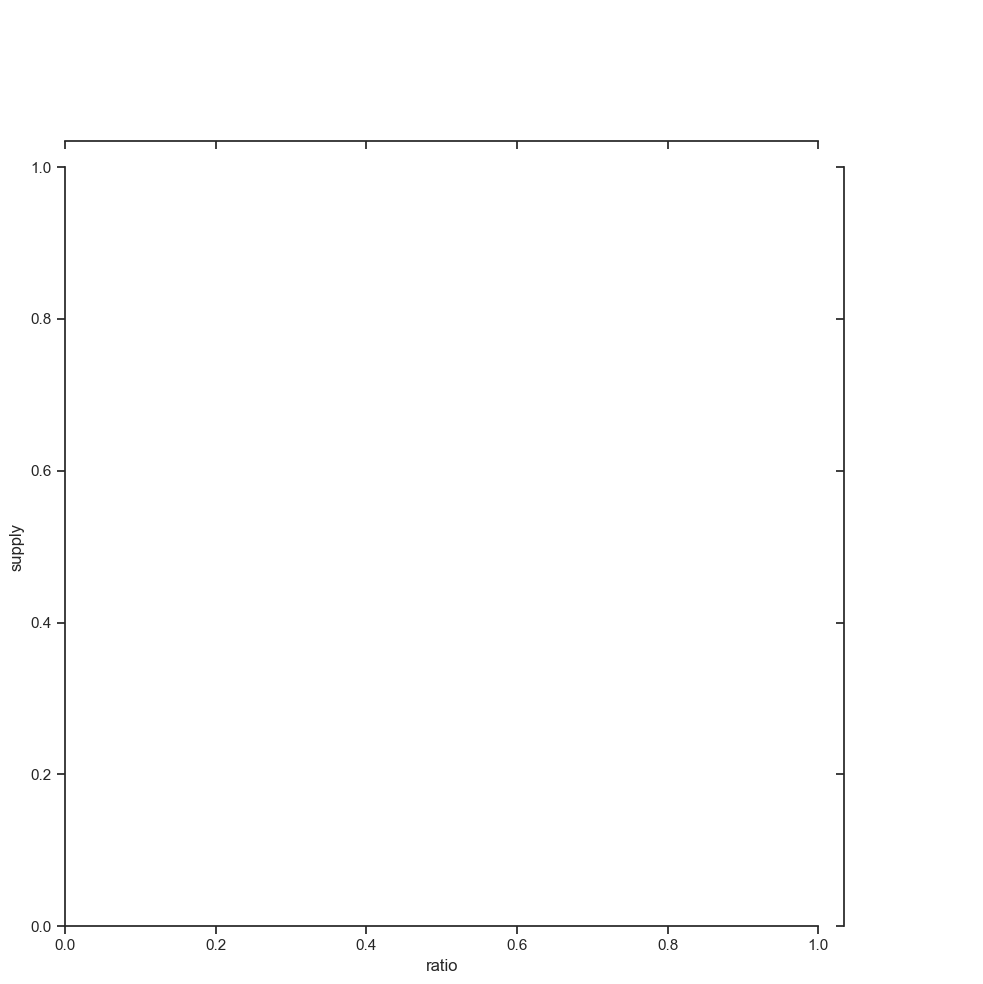

In [ ]:

custom_palette = ["#dd8452","#4c72b0",  "#55a868"]
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=solution, palette=custom_palette,
    x="ratio", y="supply",  # ylim=[None, 150],
    kind="kde", height=10
)